In [5]:
# ==================================================
# MATCH WINNER PREDICTION PIPELINE
# ==================================================

# Cell 1: Setup and Configuration
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
import warnings
import os
import sys
from datetime import datetime
import optuna

# Sklearn imports
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

# SMOTE for handling class imbalance
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    print("Installing imbalanced-learn...")
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'imbalanced-learn'])
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True

# XGBoost
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not installed.")

# Neural Network using scikit-learn MLPClassifier
from sklearn.neural_network import MLPClassifier
NN_AVAILABLE = True  # Always available with scikit-learn

# Configuration
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Paths
MODELS_DIR = Path('models')
VIZ_DIR = Path('visualizations/match_winner')
DATASETS_DIR = Path('datasets')
RAW_MATCH_DATA_PATH = DATASETS_DIR / 'Match Winner.csv'
FINAL_DATA_PATH = Path('data/match_winner/match_winner_data.csv')
REPORTS_DIR = Path('reports/match_winner')

# Create directories
for dir_path in [MODELS_DIR, VIZ_DIR, FINAL_DATA_PATH.parent, REPORTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.2

# ==================================================
# UTILITY FUNCTIONS
# ==================================================

def check_data_quality(df):
    """
    Perform comprehensive data quality check.
    """
    print("Data Shape:", df.shape)
    print("\nMissing Values:\n", df.isnull().sum()[df.isnull().sum() > 0])
    print("\nDuplicate Rows:", df.duplicated().sum())
    
    # Check for constant columns
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    if constant_cols:
        print("\nConstant Columns (to drop):", constant_cols)
    else:
        print("\nNo constant columns found.")

def tune_hyperparameters(model_class, X_train, y_train, param_fn, n_trials=20, cv=5, scoring='f1_weighted', task_type='classification'):
    """
    Reusable Optuna hyperparameter tuning function.
    """
    def objective(trial):
        params = param_fn(trial)
        model = model_class(**params)
        
        if task_type == 'classification':
            cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
        else:
            cv_strategy = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
            
        scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring=scoring, n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
        
    return study.best_params

def evaluate_classification_model(model, X_test, y_test, model_name="Model", class_names=None):
    """
    Evaluate classification model and return metrics.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    
    if y_prob is not None and len(np.unique(y_test)) > 2: # Multi-class AUC
        try:
            roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
            print(f"ROC AUC (Weighted OVR): {roc_auc:.4f}")
        except ValueError as e:
            print(f"Could not compute ROC AUC: {e}")

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    }

def plot_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    """
    Plot feature importance for tree-based models.
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Adjust top_n to not exceed number of features
        n_features = len(feature_names)
        top_n = min(top_n, n_features)
        
        plt.figure(figsize=(12, 8))
        plt.title(f"Feature Importances - {model_name}")
        plt.bar(range(top_n), importances[indices[:top_n]], align="center")
        plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
        plt.xlim([-1, top_n])
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} does not support feature importance plotting (e.g., Keras, Logistic Regression).")

print("="*80)
print("MATCH WINNER PREDICTION PIPELINE")
print("="*80)
print(f"Setup completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"SMOTE Available: {SMOTE_AVAILABLE}")
print(f"XGBoost Available: {XGB_AVAILABLE}")
print(f"Neural Network (MLP) Available: {NN_AVAILABLE}")
print("="*80)


MATCH WINNER PREDICTION PIPELINE
Setup completed at: 2025-11-20 02:43:36
SMOTE Available: True
XGBoost Available: True
Neural Network (MLP) Available: True


In [6]:
# Cell 2: Data Loading and Advanced Feature Engineering
# ==================================================
import pandas as pd
import numpy as np
from pathlib import Path

# Ensure necessary functions and paths (like check_data_quality, RAW_MATCH_DATA_PATH, FINAL_DATA_PATH) 
# are defined in a previous cell.

def load_match_data(file_path):
    """
    Load match data, standardize column names, and ensure the target column exists.
    """
    print("\n" + "="*80)
    print("DATA LOADING")
    print("="*80)
    
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")
        
    df = pd.read_csv(file_path)
    
    # Standardize columns
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # --- FIX: Standardize target column ---
    # Look for common target column names and standardize to 'match_outcome'
    possible_target_names = {
        'ftr': 'match_outcome',
        'result': 'match_outcome',
        'final_result': 'match_outcome',
        'match_result': 'match_outcome'
    }
    
    renamed = False
    for name, new_name in possible_target_names.items():
        if name in df.columns and new_name not in df.columns:
            df.rename(columns={name: new_name}, inplace=True)
            print(f"✓ Standardized target column: Renamed '{name}' to '{new_name}'")
            renamed = True
            break
            
    if 'match_outcome' not in df.columns:
        print("! WARNING: Target column 'match_outcome' not found or standardized. Please check the CSV file.")

    # Quality Check
    check_data_quality(df)
    
    print("\nColumns:", df.columns.tolist())
    
    return df

def engineer_advanced_features(df):
    """
    Create advanced features for better prediction.
    """
    print("\n" + "="*80)
    print("ADVANCED FEATURE ENGINEERING")
    print("="*80)
    
    original_columns = df.columns.tolist()  # Store original columns
    df = df.copy()
    
    # Convert match result columns to numeric (they might be 'W', 'D', 'L' strings)
    match_cols = ['hm1', 'hm2', 'hm3', 'hm4', 'hm5', 'am1', 'am2', 'am3', 'am4', 'am5']
    for col in match_cols:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = df[col].map({'W': 3, 'D': 1, 'L': 0}).fillna(0).astype(float)
    
    # 1. Goal Difference Features
    df['home_goal_advantage'] = df['htgs'] - df['atgs']
    df['away_goal_advantage'] = df['atgs'] - df['htgs']
    df['home_defense_strength'] = df['htgs'] - df['htgc']
    df['away_defense_strength'] = df['atgs'] - df['atgc']
    
    # 2. Form Momentum
    df['form_momentum'] = df['htformpts'] - df['atformpts']
    df['form_ratio'] = df['htformpts'] / (df['atformpts'] + 1)
    
    # 3. Streak Features
    df['home_streak_advantage'] = df['htwinstreak3'] - df['atlossstreak3']
    df['away_streak_advantage'] = df['atwinstreak3'] - df['htlossstreak3']
    
    # 4. Points Pressure Features
    df['points_gap'] = df['diffpts']
    df['points_ratio'] = (df['htp'] + 1) / (df['atp'] + 1)
    
    # 5. Recent Match Features (weighted)
    df['home_recent_weighted'] = (df['hm1'] * 3 + df['hm2'] * 2 + df['hm3'] * 1) / 6
    df['away_recent_weighted'] = (df['am1'] * 3 + df['am2'] * 2 + df['am3'] * 1) / 6
    df['recent_form_diff'] = df['home_recent_weighted'] - df['away_recent_weighted']
    
    # 6. Attack vs Defense Matchup
    df['home_attack_vs_away_defense'] = df['htgs'] / (df['atgc'] + 1)
    df['away_attack_vs_home_defense'] = df['atgs'] / (df['htgc'] + 1)
    
    # 7. Goal Scoring Efficiency
    df['home_goal_efficiency'] = df['htgs'] / (df['mw'] + 1)
    df['away_goal_efficiency'] = df['atgs'] / (df['mw'] + 1)
    df['goal_efficiency_diff'] = df['home_goal_efficiency'] - df['away_goal_efficiency']
    
    # 8. Consistency Features
    home_recent_matches = df[['hm1', 'hm2', 'hm3', 'hm4', 'hm5']].values
    away_recent_matches = df[['am1', 'am2', 'am3', 'am4', 'am5']].values
    df['home_consistency'] = -np.var(home_recent_matches, axis=1)
    df['away_consistency'] = -np.var(away_recent_matches, axis=1)
    
    # 9. Interaction Features
    df['gd_x_formpts'] = df['htgd'] * df['htformpts']
    df['streak_x_points'] = df['htwinstreak3'] * df['htp']
    
    # 10. Polynomial Features
    df['htgd_squared'] = df['htgd'] ** 2
    df['diffpts_squared'] = df['diffpts'] ** 2
    
    # --- FIX: Calculate new features without recalling load_match_data ---
    new_features = [col for col in df.columns if col not in original_columns]
    print(f"✓ Created {len(new_features)} new features")
    print(f"✓ Total features: {df.shape[1]}")
    
    return df

# --- Execution ---
df = load_match_data(RAW_MATCH_DATA_PATH)
df = engineer_advanced_features(df)
df.to_csv(FINAL_DATA_PATH, index=False)


DATA LOADING
✓ Standardized target column: Renamed 'ftr' to 'match_outcome'
Data Shape: (6840, 40)

Missing Values:
 Series([], dtype: int64)

Duplicate Rows: 0

No constant columns found.

Columns: ['unnamed:_0', 'date', 'hometeam', 'awayteam', 'fthg', 'ftag', 'match_outcome', 'htgs', 'atgs', 'htgc', 'atgc', 'htp', 'atp', 'hm1', 'hm2', 'hm3', 'hm4', 'hm5', 'am1', 'am2', 'am3', 'am4', 'am5', 'mw', 'htformptsstr', 'atformptsstr', 'htformpts', 'atformpts', 'htwinstreak3', 'htwinstreak5', 'htlossstreak3', 'htlossstreak5', 'atwinstreak3', 'atwinstreak5', 'atlossstreak3', 'atlossstreak5', 'htgd', 'atgd', 'diffpts', 'diffformpts']

ADVANCED FEATURE ENGINEERING
✓ Created 24 new features
✓ Total features: 64



EXPLORATORY DATA ANALYSIS (EDA)
Temporarily encoded 'match_outcome' for visualization.

Distribution of Target Variable: 'match_outcome'


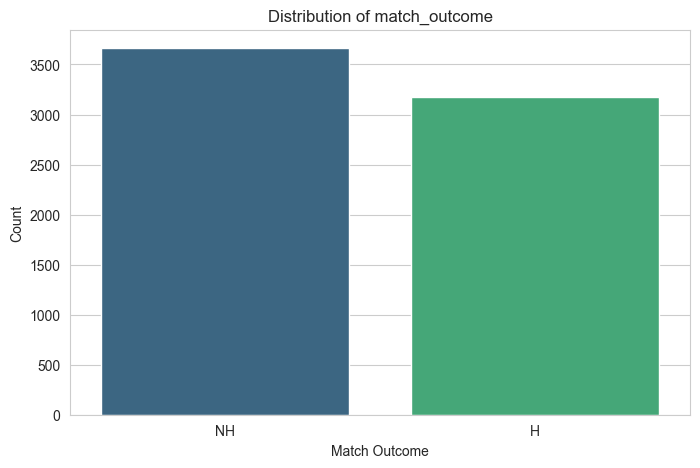


Generating Correlation Matrix for a curated subset of non-betting features...
-> Plotting correlation for 16 features.


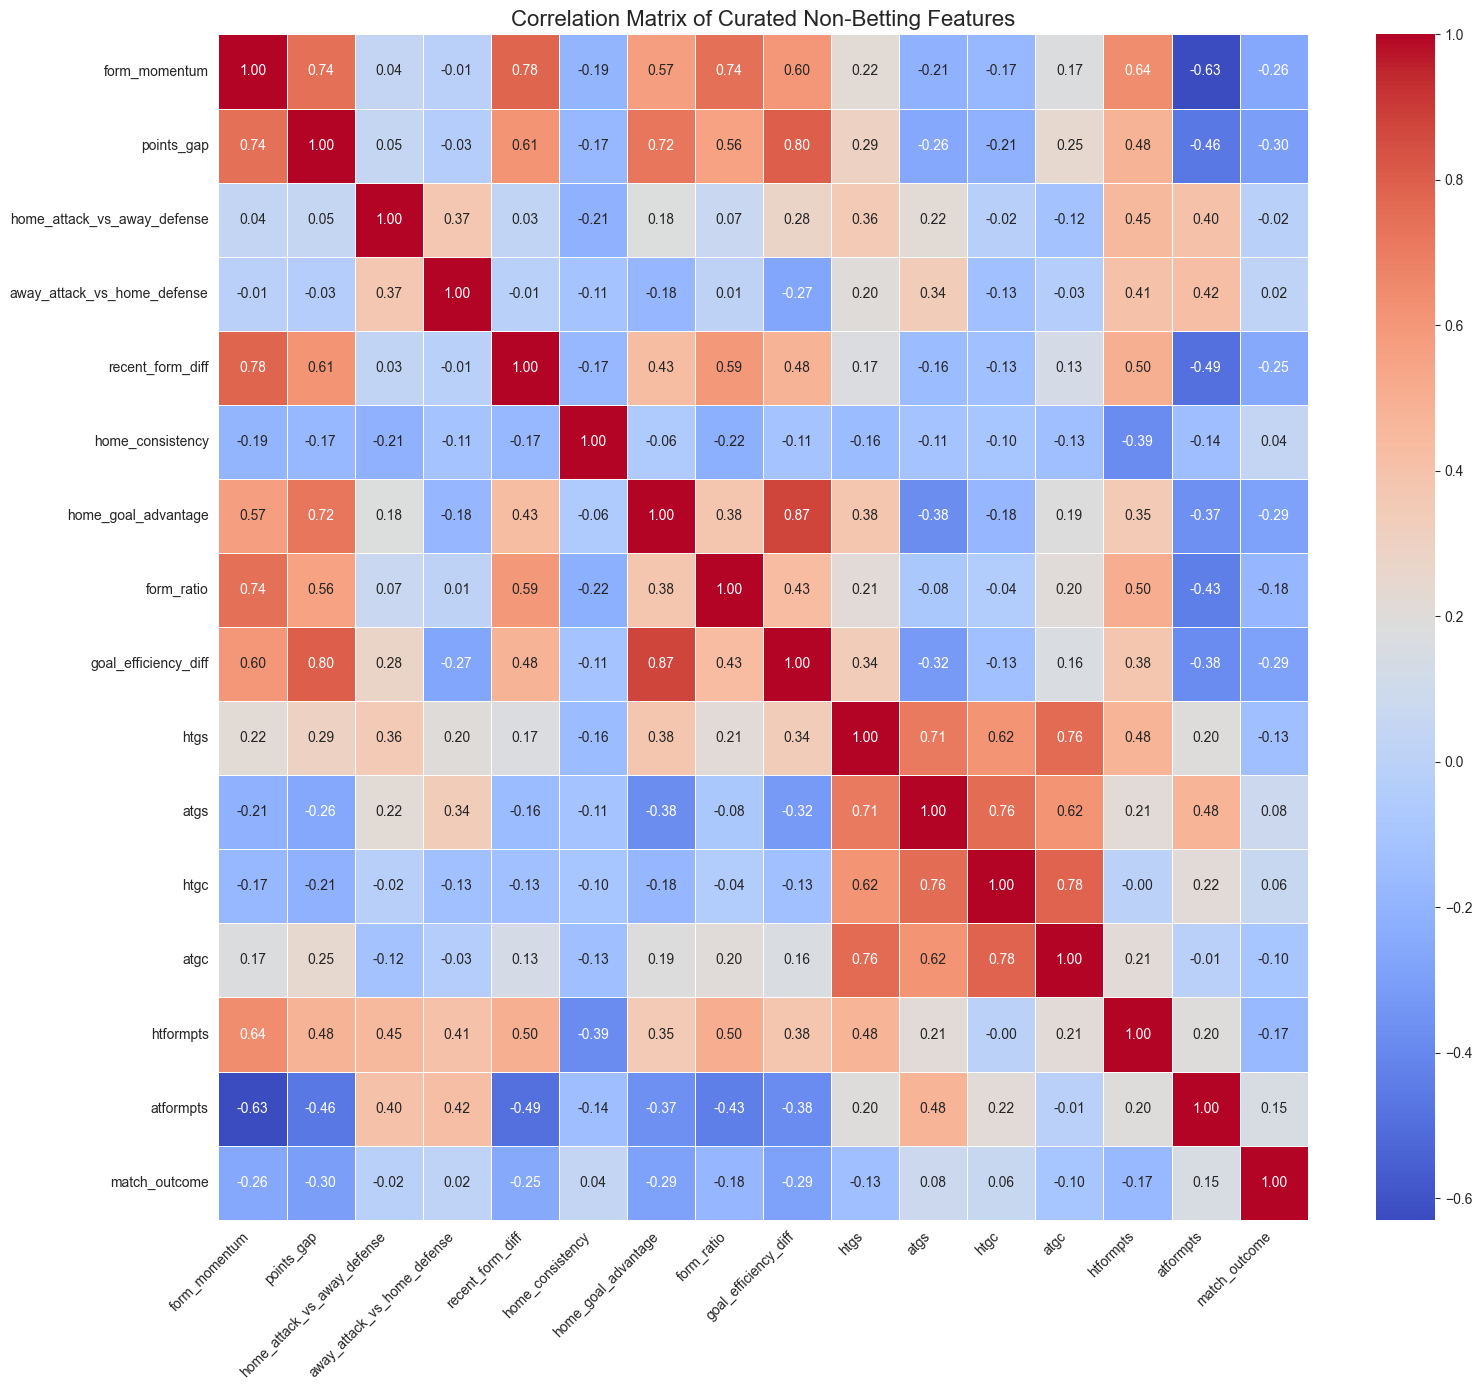

In [7]:
# Cell 3: EDA
# ==================================================

def perform_eda(df, target_col):
    """
    Perform EDA on the dataset, focusing on a curated set of non-betting features.
    """
    print("\n" + "="*80)
    print("EXPLORATORY DATA ANALYSIS (EDA)")
    print("="*80)
    
    # --- Target Distribution ---
    df_eda = df.copy()
    le = LabelEncoder()
    
    if target_col in df_eda.columns and df_eda[target_col].dtype == 'object':
        df_eda[target_col] = le.fit_transform(df_eda[target_col])
        print(f"Temporarily encoded '{target_col}' for visualization.")

    print(f"\nDistribution of Target Variable: '{target_col}'")
    plt.figure(figsize=(8, 5))
    sns.countplot(x=target_col, data=df, palette='viridis', order=df[target_col].value_counts().index)
    plt.title(f'Distribution of {target_col}')
    plt.xlabel('Match Outcome')
    plt.ylabel('Count')
    plt.show()
    
    # --- Correlation Matrix on a Curated Subset of Non-Betting Features ---
    print("\nGenerating Correlation Matrix for a curated subset of non-betting features...")
    
    curated_features = [
        # Key engineered features
        'form_momentum', 'points_gap', 'home_attack_vs_away_defense', 
        'away_attack_vs_home_defense', 'recent_form_diff', 'home_consistency',
        'home_goal_advantage', 'form_ratio', 'goal_efficiency_diff',
        # Key original stats
        'htgs', 'atgs', 'htgc', 'atgc', 'htformpts', 'atformpts',
        # Target column
        target_col
    ]
    
    # Filter to only features that actually exist in the dataframe
    existing_curated_features = [f for f in curated_features if f in df_eda.columns]
    
    if not existing_curated_features:
        print("! Could not find any of the curated features for correlation analysis. Skipping heatmap.")
        return

    print(f"-> Plotting correlation for {len(existing_curated_features)} features.")
    
    plt.figure(figsize=(16, 14))
    corr_df = df_eda[existing_curated_features].copy()
    corr_df.dropna(axis=1, how='all', inplace=True)
    
    if corr_df.empty:
        print("! All selected columns for correlation were empty. Skipping heatmap.")
        return
        
    corr_matrix = corr_df.corr()
    
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        cmap='coolwarm', 
        fmt='.2f', 
        linewidths=0.5,
        annot_kws={"size": 10}
    )
    plt.title('Correlation Matrix of Curated Non-Betting Features', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Perform EDA on the dataframe from the previous cell
perform_eda(df, 'match_outcome')


In [8]:
# Cell 4: Feature Engineering & Selection
# ==================================================

def preprocess_data(df, target_col, top_n_features=15):
    """
    Preprocess data for match winner prediction, excluding betting odds and leakage columns.
    """
    print(f"\n{'='*80}")
    print(f"FEATURE ENGINEERING & SELECTION (NO BETTING ODDS)")
    print(f"{'='*80}")
    
    data = df.copy()
    
    # --- Encode Target Variable ---
    if not pd.api.types.is_numeric_dtype(data[target_col]):
        print(f"Encoding target variable '{target_col}'...")
        le = LabelEncoder()
        data[target_col] = le.fit_transform(data[target_col])
        class_names = list(le.classes_)
        print(f"✓ Target classes: {dict(zip(range(len(class_names)), class_names))}")
    else:
        le = None
        class_names = sorted(data[target_col].unique())

    # Drop rows with NaN in target
    data.dropna(subset=[target_col], inplace=True)
    
    # --- Add all betting-related columns to the drop list ---
    betting_cols = [col for col in data.columns if any(prefix in col for prefix in ['b365', 'bw', 'iw', 'lb', 'ps', 'wh', 'sj', 'vc', 'gb', 'bs'])]
    
    # --- CRITICAL: Define Leakage Columns (Match Stats) ---
    # 'fthg' (Full Time Home Goals) and 'ftag' (Full Time Away Goals) are direct leakage.
    leakage_cols = ['fthg', 'ftag', 'home_team_goal', 'away_team_goal']
    
    # Drop non-predictive, leakage, and betting columns
    drop_cols = [
        'match_api_id', 'home_team_api_id', 'away_team_api_id', 
        'date', 
        'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 
        'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
        'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 
        'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11'
    ] + betting_cols + leakage_cols
    
    y = data[target_col]
    X = data.drop(columns=[target_col])
    
    # Drop the specified columns
    initial_drop = sorted(list(set([c for c in drop_cols if c in X.columns])))
    X = X.drop(columns=initial_drop, errors='ignore')
    
    # --- FIX: Identify and drop any remaining non-numeric columns before feature selection ---
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    if categorical_cols:
        print(f"\n! Dropping remaining categorical columns before modeling: {categorical_cols}")
        X = X.drop(columns=categorical_cols, errors='ignore')
    
    # Combine all dropped columns for the report
    dropped = sorted(list(set(initial_drop + categorical_cols)))

    # Impute missing values (median for numeric)
    numeric_cols = X.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        if X[col].isnull().any():
            median_val = X[col].median()
            X[col].fillna(median_val, inplace=True)
    
    # Feature Selection using Mutual Information
    from sklearn.feature_selection import mutual_info_classif

    print("\nPerforming feature selection with Mutual Information...")
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    # Select top N features
    top_features = mi_scores.head(top_n_features).index.tolist()
    
    # Filter X to only include top features
    X_selected = X[top_features]
    
    print("\n" + "-"*80)
    print("FEATURE SELECTION SUMMARY")
    print("-"*80)
    print(f"Target Column: {target_col}")
    print(f"\nExcluded Columns ({len(dropped)}): {', '.join(dropped)}")
    print(f"\nTop {top_n_features} Selected Features (based on Mutual Information):")
    for i, col in enumerate(X_selected.columns, 1):
        print(f"  {i}. {col} (MI Score: {mi_scores[col]:.4f})")
    print("-"*80)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    print(f"\nTraining Shape: {X_train_scaled.shape}")
    print(f"Testing Shape: {X_test_scaled.shape}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, le

# Preprocess data and select top 15 features
X_train, X_test, y_train, y_test, scaler, label_encoder = preprocess_data(df, 'match_outcome', top_n_features=15)



FEATURE ENGINEERING & SELECTION (NO BETTING ODDS)
Encoding target variable 'match_outcome'...
✓ Target classes: {0: 'H', 1: 'NH'}

! Dropping remaining categorical columns before modeling: ['hometeam', 'awayteam', 'htformptsstr', 'atformptsstr']

Performing feature selection with Mutual Information...

--------------------------------------------------------------------------------
FEATURE SELECTION SUMMARY
--------------------------------------------------------------------------------
Target Column: match_outcome

Excluded Columns (7): atformptsstr, awayteam, date, ftag, fthg, hometeam, htformptsstr

Top 15 Selected Features (based on Mutual Information):
  1. points_gap (MI Score: 0.0569)
  2. diffpts (MI Score: 0.0562)
  3. points_ratio (MI Score: 0.0510)
  4. away_goal_advantage (MI Score: 0.0504)
  5. goal_efficiency_diff (MI Score: 0.0494)
  6. home_goal_advantage (MI Score: 0.0422)
  7. atgd (MI Score: 0.0361)
  8. form_momentum (MI Score: 0.0355)
  9. recent_form_diff (MI Sco

In [9]:
# Cell 5: Model Training and Tuning
# ==================================================

def train_match_models(X_train, y_train):
    """
    Train and tune match winner models, including a Neural Network (MLP).
    """
    print("\n" + "="*80)
    print("MODEL TRAINING")
    print("="*80)
    
    best_models = {}
    
    # 1. Logistic Regression
    print("\n--- Tuning Logistic Regression ---")
    def lr_params(trial):
        return {
            'C': trial.suggest_float('C', 0.01, 10.0, log=True),
            'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
            'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
            'max_iter': 1000
        }
    lr_best_params = tune_hyperparameters(
        LogisticRegression, X_train, y_train, lr_params, n_trials=15, scoring='f1_weighted'
    )
    lr_model = LogisticRegression(**lr_best_params)
    lr_model.fit(X_train, y_train)
    best_models['LogisticRegression'] = lr_model
    
    # 2. Random Forest
    print("\n--- Tuning Random Forest ---")
    def rf_params(trial):
        return {
            'n_estimators': trial.suggest_int('n_estimators', 200, 500),
            'max_depth': trial.suggest_int('max_depth', 10, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
    rf_best_params = tune_hyperparameters(
        RandomForestClassifier, X_train, y_train, rf_params, n_trials=30, scoring='f1_weighted'
    )
    rf_model = RandomForestClassifier(**rf_best_params)
    rf_model.fit(X_train, y_train)
    best_models['RandomForest'] = rf_model
    
    # 3. XGBoost
    if XGB_AVAILABLE:
        print("\n--- Tuning XGBoost ---")
        def xgb_params(trial):
            return {
                'n_estimators': trial.suggest_int('n_estimators', 200, 500),
                'max_depth': trial.suggest_int('max_depth', 5, 15),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
                'random_state': RANDOM_STATE,
                'n_jobs': -1
            }
        xgb_best_params = tune_hyperparameters(
            xgb.XGBClassifier, X_train, y_train, xgb_params, n_trials=30, scoring='f1_weighted'
        )
        xgb_model = xgb.XGBClassifier(**xgb_best_params)
        xgb_model.fit(X_train, y_train)
        best_models['XGBoost'] = xgb_model
        
    # 4. Gradient Boosting
    print("\n--- Tuning Gradient Boosting ---")
    def gb_params(trial):
        return {
            'n_estimators': trial.suggest_int('n_estimators', 200, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'random_state': RANDOM_STATE
        }
    gb_best_params = tune_hyperparameters(
        GradientBoostingClassifier, X_train, y_train, gb_params, n_trials=30, scoring='f1_weighted'
    )
    gb_model = GradientBoostingClassifier(**gb_best_params)
    gb_model.fit(X_train, y_train)
    best_models['GradientBoosting'] = gb_model
        
    # 5. Neural Network (Deeper MLPClassifier)
    if NN_AVAILABLE:
        print("\n--- Tuning Deep Neural Network (MLP) ---")
        def mlp_params(trial):
            layer1 = trial.suggest_int('layer1', 128, 512, step=64)
            layer2 = trial.suggest_int('layer2', 64, 256, step=32)
            layer3 = trial.suggest_int('layer3', 32, 128, step=32)
            return {
                'hidden_layer_sizes': (layer1, layer2, layer3),
                'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
                'alpha': trial.suggest_float('alpha', 0.0001, 0.01, log=True),
                'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.01, log=True),
                'learning_rate': trial.suggest_categorical('learning_rate', ['adaptive', 'constant']),
                'max_iter': 500,
                'early_stopping': True,
                'validation_fraction': 0.15,
                'random_state': RANDOM_STATE
            }
        mlp_best_params_raw = tune_hyperparameters(
            MLPClassifier, X_train, y_train, mlp_params, n_trials=30, scoring='f1_weighted'
        )
        # Manually construct the correct parameters
        mlp_best_params = {
            'hidden_layer_sizes': (mlp_best_params_raw['layer1'], mlp_best_params_raw['layer2'], mlp_best_params_raw['layer3']),
            'activation': mlp_best_params_raw['activation'],
            'alpha': mlp_best_params_raw['alpha'],
            'learning_rate_init': mlp_best_params_raw['learning_rate_init'],
            'learning_rate': mlp_best_params_raw['learning_rate'],
            'max_iter': 500,
            'early_stopping': True,
            'validation_fraction': 0.15,
            'random_state': RANDOM_STATE
        }
        mlp_model = MLPClassifier(**mlp_best_params)
        mlp_model.fit(X_train, y_train)
        print("✓ Deep Neural Network training complete.")
        best_models['NeuralNetwork'] = mlp_model
    
    # 6. Stacking Ensemble (Meta-Learner)
    print("\n--- Building Stacking Ensemble ---")
    from sklearn.ensemble import StackingClassifier
    
    base_estimators = [
        ('rf', best_models['RandomForest']),
        ('lr', best_models['LogisticRegression'])
    ]
    if 'XGBoost' in best_models:
        base_estimators.append(('xgb', best_models['XGBoost']))
    if 'GradientBoosting' in best_models:
        base_estimators.append(('gb', best_models['GradientBoosting']))
    if 'NeuralNetwork' in best_models:
        base_estimators.append(('nn', best_models['NeuralNetwork']))
    
    # Use Logistic Regression as meta-learner
    stacking_model = StackingClassifier(
        estimators=base_estimators,
        final_estimator=LogisticRegression(C=1.0, max_iter=1000, random_state=RANDOM_STATE),
        cv=5,
        n_jobs=-1
    )
    print(f"Training stacking ensemble with {len(base_estimators)} base models...")
    stacking_model.fit(X_train, y_train)
    best_models['StackingEnsemble'] = stacking_model
    print("✓ Stacking Ensemble training complete.")

        
    return best_models

# Train all models
best_models = train_match_models(X_train, y_train)


[I 2025-11-20 02:43:38,388] A new study created in memory with name: no-name-fd4c0dad-1f32-4b3d-a466-ae19c2e131ef



MODEL TRAINING

--- Tuning Logistic Regression ---


[I 2025-11-20 02:43:39,729] Trial 0 finished with value: 0.6253055234500339 and parameters: {'C': 0.031419409990480075, 'solver': 'lbfgs', 'class_weight': None}. Best is trial 0 with value: 0.6253055234500339.
[I 2025-11-20 02:43:40,642] Trial 1 finished with value: 0.6289289678414345 and parameters: {'C': 0.3536265946999569, 'solver': 'liblinear', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6289289678414345.
[I 2025-11-20 02:43:41,598] Trial 2 finished with value: 0.6285732898483245 and parameters: {'C': 1.7468249245718006, 'solver': 'liblinear', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6289289678414345.
[I 2025-11-20 02:43:42,454] Trial 3 finished with value: 0.6244761839155409 and parameters: {'C': 0.1062467410280275, 'solver': 'lbfgs', 'class_weight': None}. Best is trial 1 with value: 0.6289289678414345.
[I 2025-11-20 02:43:42,478] Trial 4 finished with value: 0.6270956415974611 and parameters: {'C': 0.07964452651566517, 'solver': 'lbfgs', 'class_w

Best trial:
  Value: 0.6289289678414345
  Params: 
    C: 0.3536265946999569
    solver: liblinear
    class_weight: balanced

--- Tuning Random Forest ---


[I 2025-11-20 02:43:44,801] Trial 0 finished with value: 0.6079444929417678 and parameters: {'n_estimators': 494, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.6079444929417678.
[I 2025-11-20 02:43:45,720] Trial 1 finished with value: 0.6066397127027854 and parameters: {'n_estimators': 229, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6079444929417678.
[I 2025-11-20 02:43:46,761] Trial 2 finished with value: 0.6063073153443475 and parameters: {'n_estimators': 254, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6079444929417678.
[I 2025-11-20 02:43:47,950] Trial 3 finished with value: 0.6054036121229885 and parameters: {'n_estimators': 251, 'max_depth': 18, 'min_samples_split': 4

Best trial:
  Value: 0.6188978621946342
  Params: 
    n_estimators: 337
    max_depth: 10
    min_samples_split: 6
    min_samples_leaf: 2
    max_features: sqrt
    class_weight: balanced


[I 2025-11-20 02:44:24,299] A new study created in memory with name: no-name-043cdbe3-61ca-4f92-be30-a5baeeb27348



--- Tuning XGBoost ---


[I 2025-11-20 02:44:24,689] Trial 0 finished with value: 0.6192374263782984 and parameters: {'n_estimators': 259, 'max_depth': 6, 'learning_rate': 0.1179941934062961, 'subsample': 0.6648790597951422, 'colsample_bytree': 0.6547252749374685, 'gamma': 3.3076027320983443, 'reg_alpha': 0.9756616680710318, 'reg_lambda': 0.4220843697902158}. Best is trial 0 with value: 0.6192374263782984.
[I 2025-11-20 02:44:25,148] Trial 1 finished with value: 0.6218613364799991 and parameters: {'n_estimators': 409, 'max_depth': 9, 'learning_rate': 0.02899354525754886, 'subsample': 0.8889372035680287, 'colsample_bytree': 0.8113789908426664, 'gamma': 4.302933713287709, 'reg_alpha': 0.7009790886965865, 'reg_lambda': 0.75692201047271}. Best is trial 1 with value: 0.6218613364799991.
[I 2025-11-20 02:44:25,734] Trial 2 finished with value: 0.6080054950496676 and parameters: {'n_estimators': 458, 'max_depth': 13, 'learning_rate': 0.08073971515918604, 'subsample': 0.7720611402373301, 'colsample_bytree': 0.81623514

Best trial:
  Value: 0.6228323074725453
  Params: 
    n_estimators: 306
    max_depth: 10
    learning_rate: 0.014421411454493183
    subsample: 0.8727268641440534
    colsample_bytree: 0.8336227479452014
    gamma: 4.953722333024981
    reg_alpha: 0.3766598444355859
    reg_lambda: 0.841867873008258

--- Tuning Gradient Boosting ---


[I 2025-11-20 02:44:41,300] Trial 0 finished with value: 0.6029006705417871 and parameters: {'n_estimators': 416, 'learning_rate': 0.08612279919299105, 'max_depth': 7, 'subsample': 0.7823844698509462}. Best is trial 0 with value: 0.6029006705417871.
[I 2025-11-20 02:44:44,481] Trial 1 finished with value: 0.6015217503401715 and parameters: {'n_estimators': 260, 'learning_rate': 0.11894793207381392, 'max_depth': 5, 'subsample': 0.7032826709429109}. Best is trial 0 with value: 0.6029006705417871.
[I 2025-11-20 02:44:48,130] Trial 2 finished with value: 0.6080108937663207 and parameters: {'n_estimators': 265, 'learning_rate': 0.052180909711595024, 'max_depth': 5, 'subsample': 0.8098054348227159}. Best is trial 2 with value: 0.6080108937663207.
[I 2025-11-20 02:44:52,930] Trial 3 finished with value: 0.6012614417344495 and parameters: {'n_estimators': 206, 'learning_rate': 0.054078560545508386, 'max_depth': 9, 'subsample': 0.6417531418892192}. Best is trial 2 with value: 0.6080108937663207

Best trial:
  Value: 0.6202132365692596
  Params: 
    n_estimators: 492
    learning_rate: 0.010578585664133854
    max_depth: 3
    subsample: 0.7967795804558805


[I 2025-11-20 02:48:27,519] A new study created in memory with name: no-name-b636c3c3-851a-4d19-a453-4be9047fc315



--- Tuning Deep Neural Network (MLP) ---


[I 2025-11-20 02:48:35,448] Trial 0 finished with value: 0.623788614915488 and parameters: {'layer1': 192, 'layer2': 192, 'layer3': 128, 'activation': 'tanh', 'alpha': 0.003451848641159287, 'learning_rate_init': 0.00018574223532382157, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.623788614915488.
[I 2025-11-20 02:48:38,816] Trial 1 finished with value: 0.6238660666607239 and parameters: {'layer1': 448, 'layer2': 256, 'layer3': 128, 'activation': 'relu', 'alpha': 0.00010892583065241045, 'learning_rate_init': 0.0005137950087332127, 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.6238660666607239.
[I 2025-11-20 02:48:40,313] Trial 2 finished with value: 0.6219152726106197 and parameters: {'layer1': 128, 'layer2': 256, 'layer3': 96, 'activation': 'relu', 'alpha': 0.001286626301502063, 'learning_rate_init': 0.00016461481515496837, 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.6238660666607239.
[I 2025-11-20 02:48:41,569] Trial 3 finished with value: 

Best trial:
  Value: 0.6304471273933243
  Params: 
    layer1: 128
    layer2: 96
    layer3: 96
    activation: tanh
    alpha: 0.0026594871918393754
    learning_rate_init: 0.0017204669401915881
    learning_rate: adaptive
✓ Deep Neural Network training complete.

--- Building Stacking Ensemble ---
Training stacking ensemble with 5 base models...
✓ Stacking Ensemble training complete.



EVALUATION

Evaluating LogisticRegression
--- LogisticRegression Evaluation ---
Accuracy: 0.6520
Precision (Weighted): 0.6524
Recall (Weighted): 0.6520
F1 Score (Weighted): 0.6522

Classification Report:

              precision    recall  f1-score   support

           H       0.62      0.63      0.63       635
          NH       0.68      0.67      0.67       733

    accuracy                           0.65      1368
   macro avg       0.65      0.65      0.65      1368
weighted avg       0.65      0.65      0.65      1368



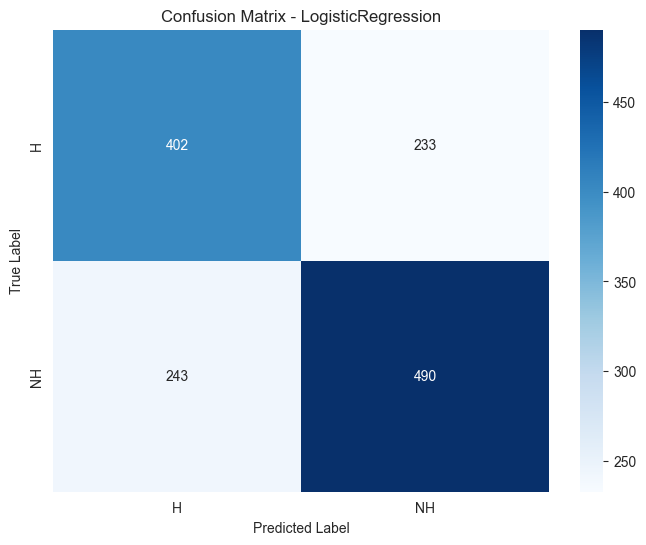


✓ Model saved to: models\match_winner_LogisticRegression.joblib

Evaluating RandomForest
--- RandomForest Evaluation ---
Accuracy: 0.6265
Precision (Weighted): 0.6250
Recall (Weighted): 0.6265
F1 Score (Weighted): 0.6239

Classification Report:

              precision    recall  f1-score   support

           H       0.61      0.54      0.57       635
          NH       0.64      0.70      0.67       733

    accuracy                           0.63      1368
   macro avg       0.62      0.62      0.62      1368
weighted avg       0.63      0.63      0.62      1368



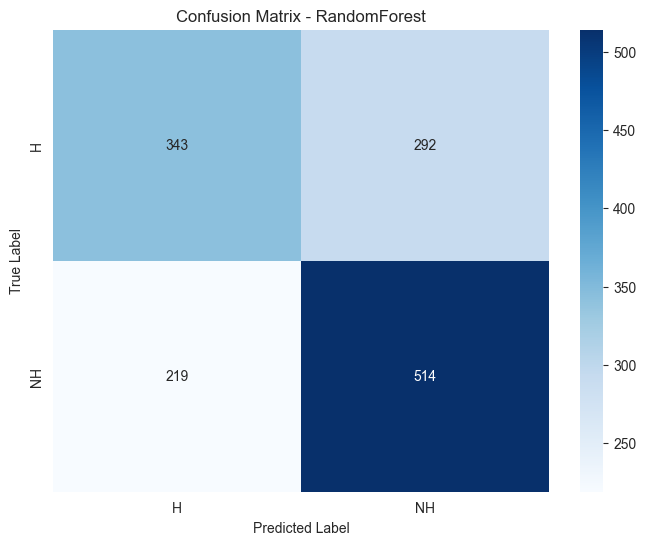


Feature Importance for RandomForest:


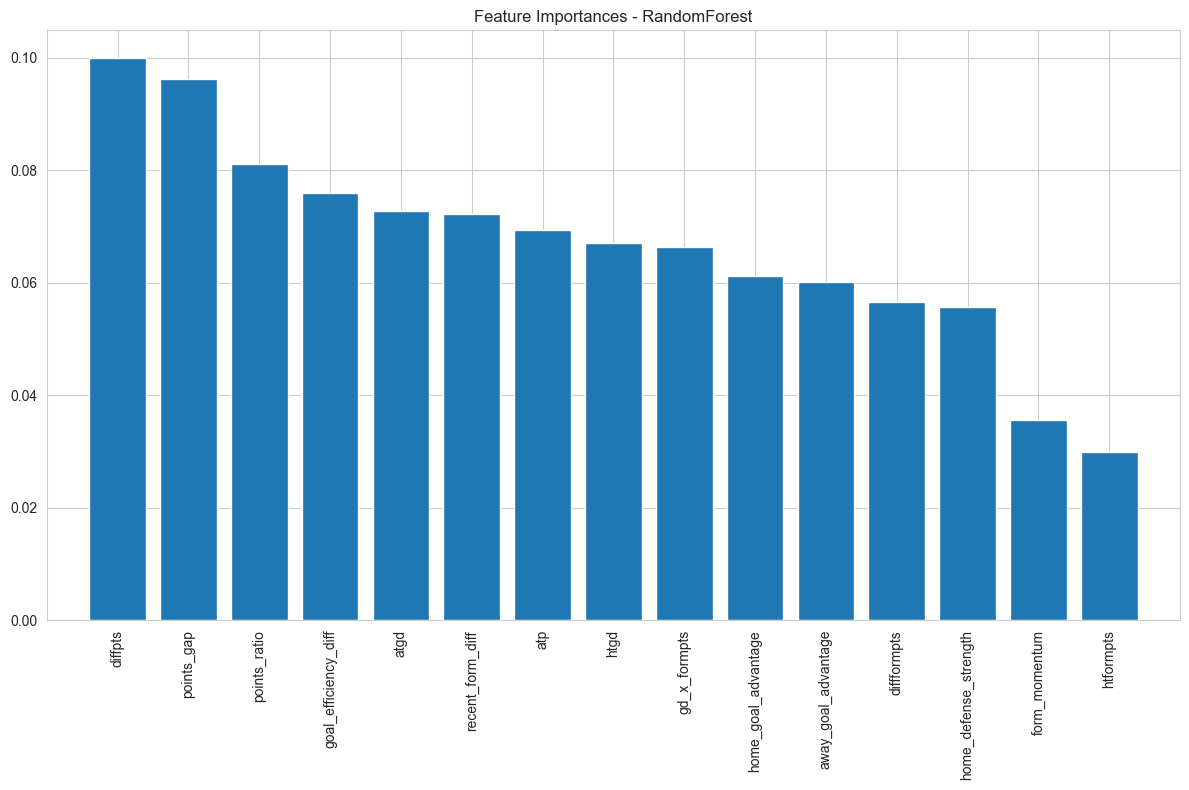


✓ Model saved to: models\match_winner_RandomForest.joblib

Evaluating XGBoost
--- XGBoost Evaluation ---
Accuracy: 0.6630
Precision (Weighted): 0.6664
Recall (Weighted): 0.6630
F1 Score (Weighted): 0.6555

Classification Report:

              precision    recall  f1-score   support

           H       0.68      0.51      0.59       635
          NH       0.65      0.79      0.72       733

    accuracy                           0.66      1368
   macro avg       0.67      0.65      0.65      1368
weighted avg       0.67      0.66      0.66      1368



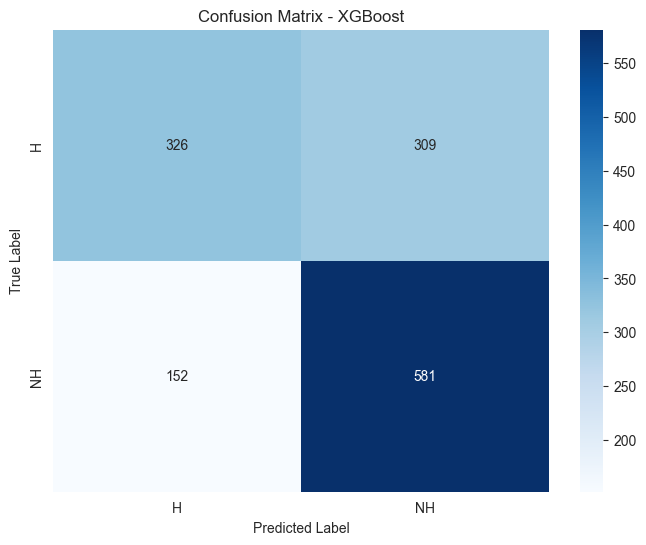


Feature Importance for XGBoost:


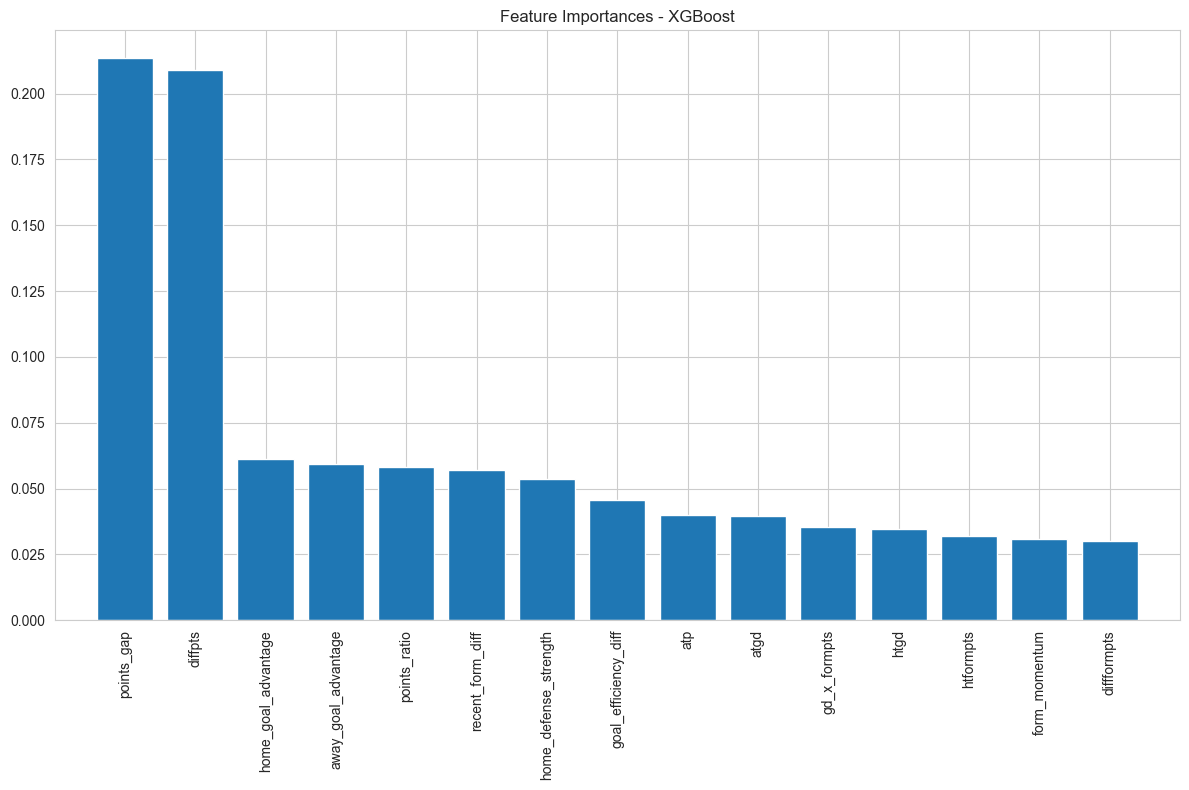


✓ Model saved to: models\match_winner_XGBoost.joblib

Evaluating GradientBoosting
--- GradientBoosting Evaluation ---
Accuracy: 0.6659
Precision (Weighted): 0.6687
Recall (Weighted): 0.6659
F1 Score (Weighted): 0.6593

Classification Report:

              precision    recall  f1-score   support

           H       0.68      0.52      0.59       635
          NH       0.66      0.79      0.72       733

    accuracy                           0.67      1368
   macro avg       0.67      0.66      0.65      1368
weighted avg       0.67      0.67      0.66      1368



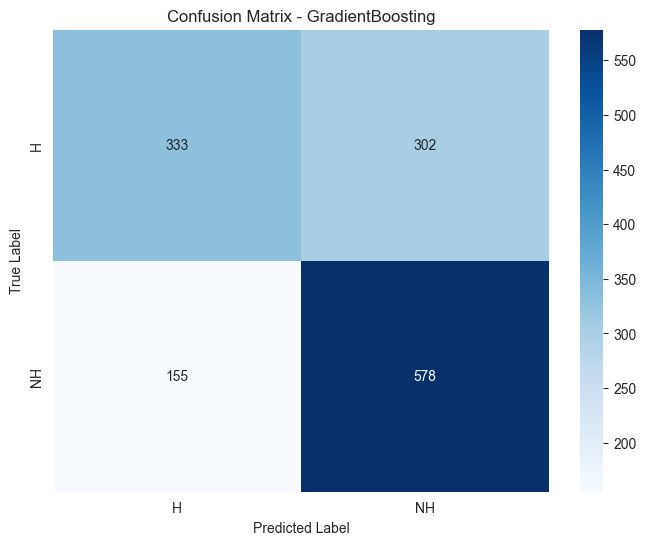


Feature Importance for GradientBoosting:


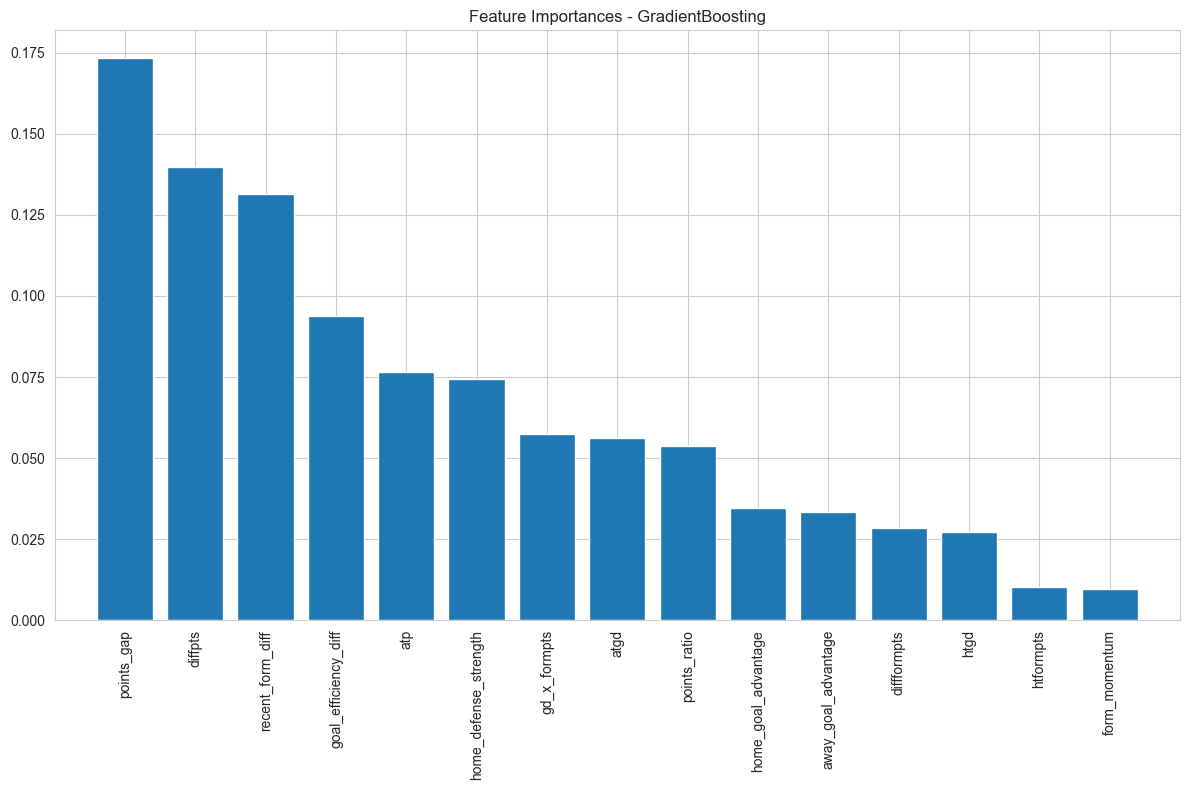


✓ Model saved to: models\match_winner_GradientBoosting.joblib

Evaluating NeuralNetwork
--- NeuralNetwork Evaluation ---
Accuracy: 0.6608
Precision (Weighted): 0.6599
Recall (Weighted): 0.6608
F1 Score (Weighted): 0.6593

Classification Report:

              precision    recall  f1-score   support

           H       0.65      0.59      0.62       635
          NH       0.67      0.72      0.69       733

    accuracy                           0.66      1368
   macro avg       0.66      0.66      0.66      1368
weighted avg       0.66      0.66      0.66      1368



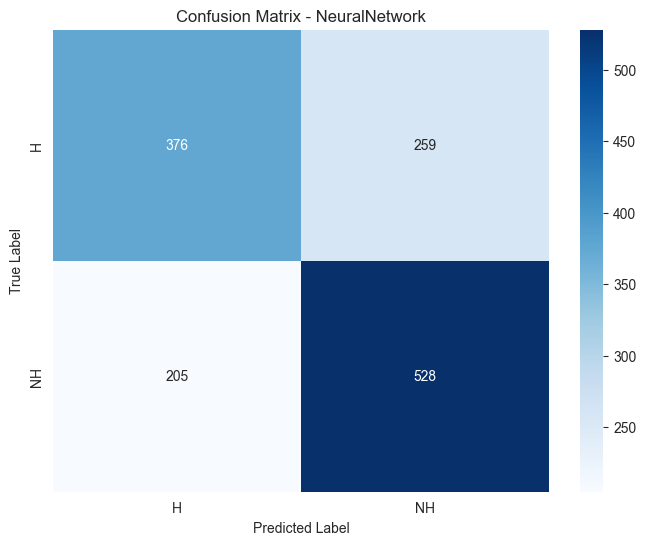


✓ Model saved to: models\match_winner_NeuralNetwork.joblib

Evaluating StackingEnsemble
--- StackingEnsemble Evaluation ---
Accuracy: 0.6652
Precision (Weighted): 0.6649
Recall (Weighted): 0.6652
F1 Score (Weighted): 0.6621

Classification Report:

              precision    recall  f1-score   support

           H       0.66      0.57      0.61       635
          NH       0.67      0.75      0.71       733

    accuracy                           0.67      1368
   macro avg       0.66      0.66      0.66      1368
weighted avg       0.66      0.67      0.66      1368



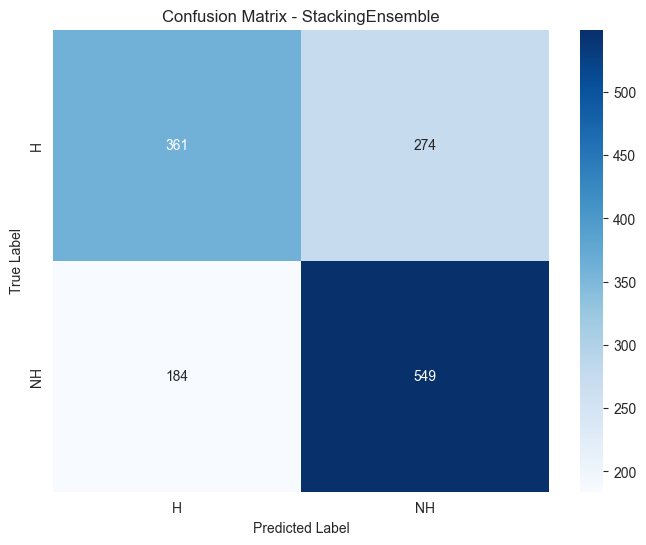


✓ Model saved to: models\match_winner_StackingEnsemble.joblib

MODEL COMPARISON
             Model  Accuracy  Precision   Recall  F1_Score
LogisticRegression  0.652047   0.652445 0.652047  0.652211
      RandomForest  0.626462   0.625000 0.626462  0.623931
           XGBoost  0.663012   0.666363 0.663012  0.655543
  GradientBoosting  0.665936   0.668682 0.665936  0.659294
     NeuralNetwork  0.660819   0.659882 0.660819  0.659312
  StackingEnsemble  0.665205   0.664896 0.665205  0.662119

✓ Comparison saved to: reports\match_winner\model_comparison.csv

🏆 Best Model: StackingEnsemble
   F1 Score: 0.6621
   Accuracy: 0.6652
✓ Best model saved to: models\match_winner_best_model.joblib
✓ Metadata saved to: models\ps4_match_winner_metadata.json

✅ MATCH WINNER PIPELINE COMPLETED!


In [10]:
# Cell 6: Evaluation
# ==================================================

print("\n" + "="*80)
print("EVALUATION")
print("="*80)

results = []
# --- FIX: Use the class names from the label encoder ---
class_names = list(label_encoder.classes_) if label_encoder else sorted(y_train.unique())


for name, model in best_models.items():
    print(f"\n{'='*60}")
    print(f"Evaluating {name}")
    print(f"{'='*60}")
    
    metrics = evaluate_classification_model(
        model, X_test, y_test, 
        model_name=name, 
        class_names=class_names
    )
    results.append(metrics)
    
    # Feature Importance (Tree models only)
    if name in ['RandomForest', 'XGBoost', 'GradientBoosting']:
        print(f"\nFeature Importance for {name}:")
        plot_feature_importance(model, X_train.columns, model_name=name)
        
    # Save model
    model_path = MODELS_DIR / f'match_winner_{name}.joblib'
    joblib.dump(model, model_path)
    print(f"\n✓ Model saved to: {model_path}")

# Comparison
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(results_df.to_string(index=False))

results_df.to_csv(REPORTS_DIR / 'model_comparison.csv', index=False)
print(f"\n✓ Comparison saved to: {REPORTS_DIR / 'model_comparison.csv'}")

# Identify best model
best_idx = results_df['F1_Score'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_model = best_models[best_model_name]

# Save best model
best_model_path = MODELS_DIR / 'match_winner_best_model.joblib'
joblib.dump(best_model, best_model_path)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1 Score: {results_df.loc[best_idx, 'F1_Score']:.4f}")
print(f"   Accuracy: {results_df.loc[best_idx, 'Accuracy']:.4f}")
print(f"✓ Best model saved to: {best_model_path}")

# Save metadata
metadata = {
    'pipeline': 'Match Winner Prediction',
    'problem_statement': 'PS4 - Match Winner',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'best_model': best_model_name,
    'target_classes': class_names,
    'metrics': results_df[results_df['Model'] == best_model_name].to_dict('records')[0],
    'all_results': results_df.to_dict('records'),
    'features_used': X_train.columns.tolist(),
    'target_column': 'match_outcome', # Hardcode as it's now standardized
    'random_state': RANDOM_STATE,
    'test_size': TEST_SIZE
}

metadata_path = MODELS_DIR / 'ps4_match_winner_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print(f"✓ Metadata saved to: {metadata_path}")

print("\n" + "="*80)
print("✅ MATCH WINNER PIPELINE COMPLETED!")
print("="*80)
